In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/code/')
from func import set_proj_env, my_get_cmap, get_fdr_p

In [4]:
train_test_str = 'squeakycleanExclude'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125 250
extra_str = ''
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                                        parc_str = parc_str, parc_scale = parc_scale)

In [5]:
# output file prefix
outfile_prefix = exclude_str+'_'+parc_str+'_'+str(parc_scale)+'_'
outfile_prefix

't1Exclude_schaefer_400_'

### Setup directory variables

In [6]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)
    
outputdir = os.path.join(os.environ['PIPELINEDIR'], '8_prepare_mediation', 'out')
print(outputdir)
if not os.path.exists(outputdir): os.makedirs(outputdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/3_output/figs
/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/2_pipeline/8_prepare_mediation/out


## Setup plots

In [7]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'talk', font_scale = 1)
cmap = my_get_cmap('pair')

phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
phenos_label_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear']
metrics = ['ct', 'vol']
metrics_label_short = ['Thickness', 'Volume']
metrics_label = ['Thickness', 'Volume']

## Load data

In [8]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'train.csv'))
df_train.set_index(['bblid', 'scanid'], inplace = True)
df_node_train = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid'], inplace = True)

# Test
df_test = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'test.csv'))
df_test.set_index(['bblid', 'scanid'], inplace = True)
df_node_test = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'resp_test.csv'))
df_node_test.set_index(['bblid', 'scanid'], inplace = True)

# concat
df = pd.concat((df_train, df_test), axis = 0); print(df.shape)
df_node = pd.concat((df_node_train, df_node_test), axis = 0); print(df_node.shape)

(1393, 47)
(1393, 800)


### Sex effects on y

male = 0, female = 1

In [9]:
stats = pd.DataFrame(index = phenos, columns = ['test_stat', 'pval'])

for i, pheno in enumerate(phenos):
    x = df.loc[df.loc[:,'sex_adj'] == 1,pheno]
    y = df.loc[df.loc[:,'sex_adj'] == 0,pheno]
    
    test_output = sp.stats.ttest_ind(x,y)
    stats.loc[pheno,'test_stat'] = test_output[0]
    stats.loc[pheno,'pval'] = test_output[1]
    
stats.loc[:,'pval_corr'] = get_fdr_p(stats.loc[:,'pval'])
stats.loc[:,'sig'] = stats.loc[:,'pval_corr'] < 0.05

stats

,test_stat,pval,pval_corr,sig
Overall_Psychopathology,1.47246,0.141122,0.141122,False
Psychosis_Positive,-1.98524,0.0473137,0.0567765,False
Psychosis_NegativeDisorg,-4.29113,1.90054e-05,2.85082e-05,True
AnxiousMisery,4.60824,4.433e-06,8.86599e-06,True
Externalizing,-5.67275,1.7071e-08,5.12129e-08,True
Fear,6.33431,3.21155e-10,1.92693e-09,True


sex_adj = male = 0, female = 1

sex_adj_flip = female = 0, male = 1

In [10]:
df['sex_adj_flip'] = df['sex_adj'] ^ 1
df[['sex_adj','sex_adj_flip']].head()

,,sex_adj,sex_adj_flip
bblid,scanid,,
80199,2637,0,1
80249,2648,1,0
80854,2675,0,1
81826,2682,1,0
82232,2706,1,0


In [11]:
phenos = list(stats.loc[stats.loc[:,'sig'],:].index)
phenos

['Psychosis_NegativeDisorg', 'AnxiousMisery', 'Externalizing', 'Fear']

In [12]:
use_flip = stats.loc[phenos,'test_stat'] < 0
use_flip

Psychosis_NegativeDisorg     True
AnxiousMisery               False
Externalizing                True
Fear                        False
Name: test_stat, dtype: bool

## Load nispat outputs

In [13]:
z_cv = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '3_run_normative', outfile_prefix+'out_cv', 'Z.txt'), delimiter = ' ').transpose()
df_z_cv = pd.DataFrame(data = z_cv, index = df_node_train.index, columns = df_node_train.columns)

z = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '3_run_normative', outfile_prefix+'out', 'Z.txt'), delimiter = ' ').transpose()
df_z_test = pd.DataFrame(data = z, index = df_node_test.index, columns = df_node_test.columns)

# concat
df_z = pd.concat((df_z_cv,df_z_test), axis = 0); print(df_z.shape)

(1393, 800)


### Are there sex effects on devations?

In [14]:
for metric in metrics:
    x = df_z.loc[df.loc[:,'sex_adj'] == 0,:].filter(regex = metric)
    y = df_z.loc[df.loc[:,'sex_adj'] == 1,:].filter(regex = metric)
        
    ttest_output = sp.stats.ttest_ind(x,y)

    print(metric, np.sum(get_fdr_p(ttest_output[1]) < 0.05))
    print(df_z.filter(regex = metric).columns[get_fdr_p(ttest_output[1]) < 0.05])

ct 65
Index(['ct_8', 'ct_10', 'ct_25', 'ct_26', 'ct_28', 'ct_37', 'ct_40', 'ct_48',
       'ct_55', 'ct_72', 'ct_74', 'ct_78', 'ct_81', 'ct_86', 'ct_102',
       'ct_120', 'ct_123', 'ct_124', 'ct_132', 'ct_133', 'ct_134', 'ct_136',
       'ct_137', 'ct_138', 'ct_145', 'ct_147', 'ct_152', 'ct_163', 'ct_169',
       'ct_173', 'ct_180', 'ct_181', 'ct_199', 'ct_208', 'ct_210', 'ct_212',
       'ct_215', 'ct_216', 'ct_219', 'ct_221', 'ct_222', 'ct_225', 'ct_226',
       'ct_232', 'ct_233', 'ct_246', 'ct_259', 'ct_263', 'ct_264', 'ct_266',
       'ct_272', 'ct_273', 'ct_318', 'ct_319', 'ct_325', 'ct_336', 'ct_338',
       'ct_339', 'ct_347', 'ct_351', 'ct_356', 'ct_359', 'ct_381', 'ct_385',
       'ct_388'],
      dtype='object')
vol 65
Index(['vol_12', 'vol_26', 'vol_28', 'vol_43', 'vol_45', 'vol_61', 'vol_69',
       'vol_71', 'vol_72', 'vol_74', 'vol_80', 'vol_85', 'vol_87', 'vol_88',
       'vol_89', 'vol_92', 'vol_93', 'vol_106', 'vol_110', 'vol_112',
       'vol_122', 'vol_132', 'vol_1

## Examine dimensionality reduction

ct 12 0.38859459617112024
vol 9 0.3635382810611284


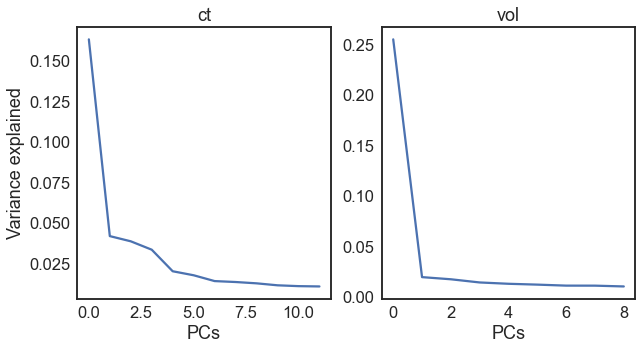

In [15]:
f, ax = plt.subplots(1,2)
f.set_figwidth(10)
f.set_figheight(5)

N_components = []

for i, metric in enumerate(metrics):
    x = df_z.filter(regex = metric)

    # find number of PCs that explain 80% variance
    pca = PCA(n_components = x.shape[1], svd_solver = 'full')
    pca.fit(StandardScaler().fit_transform(x))
    cum_var = np.cumsum(pca.explained_variance_ratio_)
#     n_components = np.where(cum_var >= 0.8)[0][0]+1
    var_idx = pca.explained_variance_ratio_ >= .01
    n_components = np.sum(var_idx)
    N_components.append(n_components)
    
    var_exp = cum_var[n_components-1]

    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=n_components, svd_solver='full', random_state = 0)
    pca.fit(x)

    ax[i].plot(pca.explained_variance_ratio_)
    ax[i].set_xlabel('PCs')
    if i == 0:
        ax[i].set_ylabel('Variance explained')
    ax[i].set_title(metric)
    ax[i].tick_params(pad = -2)

    print(metric, n_components, np.sum(pca.explained_variance_ratio_))

## Save out input files for matlab

In [16]:
np.savetxt(os.path.join(outputdir,outfile_prefix+'Y_labels.txt'), phenos, fmt="%s")
np.savetxt(os.path.join(outputdir,outfile_prefix+'use_flip.txt'), use_flip, fmt="%i")

np.savetxt(os.path.join(outputdir,outfile_prefix+'M_labels.txt'), metrics, fmt="%s")
np.savetxt(os.path.join(outputdir,outfile_prefix+'N_components.txt'), N_components, fmt="%i")

df.loc[:,['sex_adj','sex_adj_flip']].to_csv(os.path.join(outputdir,outfile_prefix+'X.csv'))
df_z.to_csv(os.path.join(outputdir,outfile_prefix+'M.csv'))
df.loc[:,phenos].to_csv(os.path.join(outputdir,outfile_prefix+'Y.csv'))

## Plot PCs

In [17]:
import matplotlib.image as mpimg
from brain_plot_func import roi_to_vtx, brain_plot

Notebook initialized with png backend.


In [18]:
if parc_str == 'schaefer':
    subject_id = 'fsaverage'
elif parc_str == 'lausanne':
    subject_id = 'lausanne125'

In [19]:
figs_to_delete = []

for metric in metrics:
    x = df_z.filter(regex = metric)
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=10, svd_solver='full', random_state = 0)
    pca.fit(x)

    for pc in np.arange(0,3):       
        roi_data = pca.components_[pc,:]
        for hemi in ('lh', 'rh'):
            fig_str = hemi + '_' + metric + '_pc_' + str(pc)
            figs_to_delete.append('ventral_'+fig_str)
            figs_to_delete.append('med_'+fig_str)
            figs_to_delete.append('lat_'+fig_str)

            if subject_id == 'lausanne125':
                parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
            elif subject_id == 'fsaverage':
                parc_file = os.path.join('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                         hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

            # project subject's data to vertices
            brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi, surf = 'inflated', showcolorbar = True)

0.07714681116074784
0.08246765999306742
0.1501888616476993
0.15113800285326023
0.13318502403565155
0.13178306851229254
0.06676196955210091
0.07076083542756498
0.1939071253690544
0.190247180498789
0.158277726426469
0.14863462467508706


ct 0


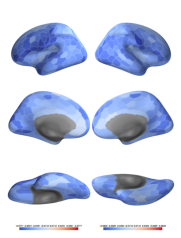

ct 1


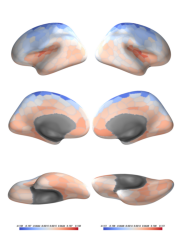

ct 2


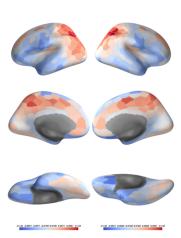

vol 0


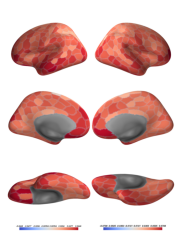

vol 1


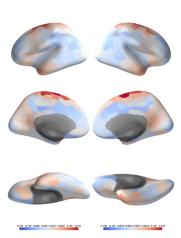

vol 2


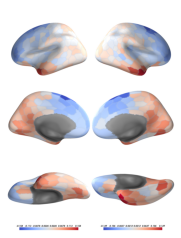

In [20]:
for metric in metrics:
    for pc in np.arange(0,3):
        f, axes = plt.subplots(3, 2)
        f.set_figwidth(3)
        f.set_figheight(5)
        plt.subplots_adjust(wspace=0, hspace=-0.465)

        print(metric, pc)
        # column 0:
        fig_str = 'lh_'+metric+'_pc_'+str(pc)+'.png'
        try:
            image = mpimg.imread('ventral_' + fig_str); axes[2,0].imshow(image); axes[2,0].axis('off')
        except FileNotFoundError: axes[2,0].axis('off')
        try:
            image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
        except FileNotFoundError: axes[1,0].axis('off')
        try:
        #     axes[0,0].set_title('Thickness (left)')
            image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
        except FileNotFoundError: axes[0,0].axis('off')

        # column 1:
        fig_str = 'rh_'+metric+'_pc_'+str(pc)+'.png'
        try:
        #     axes[0,1].set_title('Thickness (right)')
            image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
        except FileNotFoundError: axes[0,1].axis('off')
        try:
            image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
        except FileNotFoundError: axes[1,1].axis('off')
        try:
            image = mpimg.imread('ventral_' + fig_str); axes[2,1].imshow(image); axes[2,1].axis('off')
        except FileNotFoundError: axes[2,1].axis('off')

        plt.show()
        f.savefig(outfile_prefix+metric+'_pc_'+str(pc)+'.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        # f.savefig(metric+'_'+pheno+'_pdm.svg', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)

In [21]:
for file in figs_to_delete:
    try:
        os.remove(os.path.join(figdir,file+'.png'))
    except:
        print(file, 'not found')